In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `C:\Users\tge13\Documents\optimal_control_julia\lec_7\Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays

In [3]:
# Discrete dynamics
h = 0.1   # time step
A = [1 h; 0 1]
B = [0.5*h*h; h]

2-element Vector{Float64}:
 0.005000000000000001
 0.1

In [4]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time
N = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(N-1), step=h));

In [5]:
# Cost weights
Q = sparse(1.0*I(2))
R = sparse(1.0*I(1))
Qn = sparse(1.0*I(2))

2×2 SparseMatrixCSC{Float64, Int64} with 2 stored entries:
 1.0   ⋅ 
  ⋅   1.0

In [6]:
#Cost function
function J(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(N-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

J (generic function with 1 method)

In [7]:
# Initial conditions
x0 = [1.0; 0]

2-element Vector{Float64}:
 1.0
 0.0

## QP form Cost Function

In [8]:
# julia kron ref: https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#Base.kron
# Hessian
H = blockdiag(R, kron(I(N-2), blockdiag(Q, R)), Qn)
H[1:7,1:7]

7×7 SparseMatrixCSC{Float64, Int64} with 7 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

In [9]:
C = kron(I(N-1), [B -I(n)])

for k in 1:(N-2)
    C[(k*n).+(1:n), (k*(m+n)-n).+(1:n)] .= A
end

C[1:8,1:10]

8×10 SparseMatrixCSC{Float64, Int64} with 23 stored entries:
 0.005  -1.0    ⋅    ⋅       ⋅     ⋅    ⋅       ⋅     ⋅    ⋅ 
 0.1      ⋅   -1.0   ⋅       ⋅     ⋅    ⋅       ⋅     ⋅    ⋅ 
  ⋅      1.0   0.1  0.005  -1.0    ⋅    ⋅       ⋅     ⋅    ⋅ 
  ⋅       ⋅    1.0  0.1      ⋅   -1.0   ⋅       ⋅     ⋅    ⋅ 
  ⋅       ⋅     ⋅    ⋅      1.0   0.1  0.005  -1.0    ⋅    ⋅ 
  ⋅       ⋅     ⋅    ⋅       ⋅    1.0  0.1      ⋅   -1.0   ⋅ 
  ⋅       ⋅     ⋅    ⋅       ⋅     ⋅    ⋅      1.0   0.1  0.005
  ⋅       ⋅     ⋅    ⋅       ⋅     ⋅    ⋅       ⋅    1.0  0.1

In [10]:
d = [ -A*x0; zeros(size(C, 1) - n)]

200-element Vector{Float64}:
 -1.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [11]:
z = [ H C'; C zeros(size(C, 1),size(C, 1)) ] \ [ zeros(size(H, 1)); d]

# parse state x and λ
state = z[1:size(H, 1)]
λ = z[size(H, 1)+1:end]

# reshape state into [ u; x ] form
state = reshape(state, m+n, (N-1))
u_hist = state[m,:]
x_hist = state[m+1:end,:]

# add initial state
x_hist = [ x0 x_hist ]

2×101 Matrix{Float64}:
 1.0   0.995415    0.98243    0.962499  …  -0.00020465   -0.000147841
 0.0  -0.0917074  -0.167995  -0.230614      0.000570878   0.000565299

In [12]:
state

3×100 Matrix{Float64}:
 -0.917074   -0.762873  -0.626189  -0.505492  …  -0.000110377  -5.57907e-5
  0.995415    0.98243    0.962499   0.93691      -0.00020465   -0.000147841
 -0.0917074  -0.167995  -0.230614  -0.281163      0.000570878   0.000565299

In [13]:
u_hist'

1×100 adjoint(::Vector{Float64}) with eltype Float64:
 -0.917074  -0.762873  -0.626189  -0.505492  …  -0.000110377  -5.57907e-5

In [14]:
x_hist

2×101 Matrix{Float64}:
 1.0   0.995415    0.98243    0.962499  …  -0.00020465   -0.000147841
 0.0  -0.0917074  -0.167995  -0.230614      0.000570878   0.000565299

## Plotting

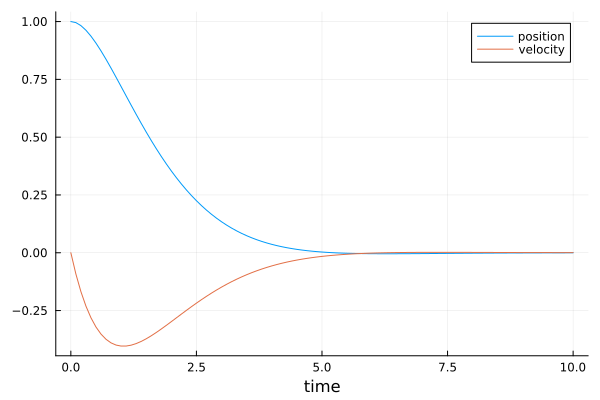

In [15]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times, x_hist[1,:], label="position")
plot!(times, x_hist[2,:], label="velocity")
xlabel!("time")

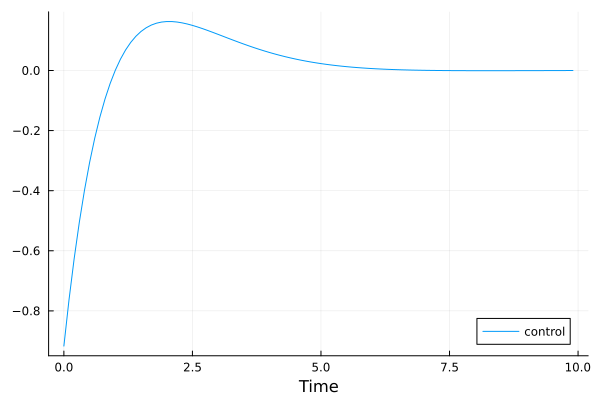

In [16]:
plot(times[1:end-1], u_hist, label="control")
xlabel!("Time")

In [18]:
J(x_hist,u_hist)

8.917464698669114

## Experiment - Higher R

In [19]:
# Cost weights
Q = sparse(1.0*I(2))
R = sparse(10.0*I(1))
Qn = sparse(1.0*I(2))

2×2 SparseMatrixCSC{Float64, Int64} with 2 stored entries:
 1.0   ⋅ 
  ⋅   1.0

In [20]:
H = blockdiag(R, kron(I(N-2), blockdiag(Q, R)), Qn)

C = kron(I(N-1), [B -I(n)])
for k in 1:(N-2)
    C[(k*n).+(1:n), (k*(m+n)-n).+(1:n)] .= A
end

d = [ -A*x0; zeros(size(C, 1) - n)]

z = [ H C'; C zeros(size(C, 1),size(C, 1)) ] \ [ zeros(size(H, 1)); d]

# parse state x and λ
state = z[1:size(H, 1)]
λ = z[size(H, 1)+1:end]

# reshape state into [ u; x ] form
state = reshape(state, m+n, (N-1))
u_hist = state[m,:]
x_hist = state[m+1:end,:]

# add initial state
x_hist = [ x0 x_hist ]

2×101 Matrix{Float64}:
 1.0   0.998487    0.994075    0.987018   …  -0.044393    -0.0448818
 0.0  -0.0302664  -0.0579577  -0.0832011     -0.00489129  -0.00488416

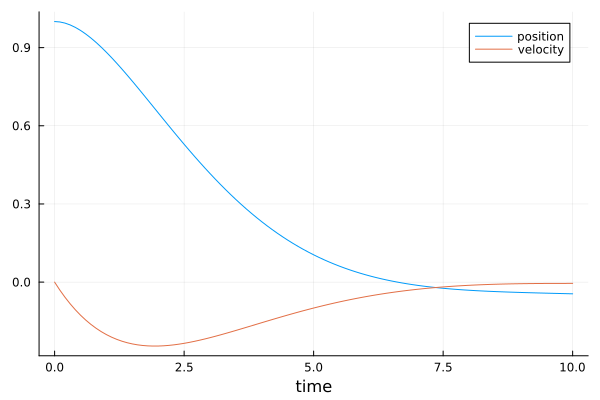

In [21]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times, x_hist[1,:], label="position")
plot!(times, x_hist[2,:], label="velocity")
xlabel!("time")

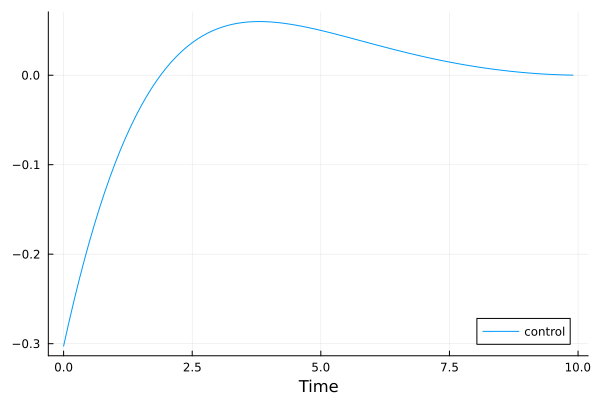

In [22]:
plot(times[1:end-1], u_hist, label="control")
xlabel!("Time")

In [23]:
J(x_hist,u_hist)

13.776873077599783

## Experiment - Longer Time Horizon

In [24]:
Tfinal = 100.0 # final time
N = Int(Tfinal/h)+1    # number of time steps

1001

In [25]:
H = blockdiag(R, kron(I(N-2), blockdiag(Q, R)), Qn)

C = kron(I(N-1), [B -I(n)])
for k in 1:(N-2)
    C[(k*n).+(1:n), (k*(m+n)-n).+(1:n)] .= A
end

d = [ -A*x0; zeros(size(C, 1) - n)]

z = [ H C'; C zeros(size(C, 1),size(C, 1)) ] \ [ zeros(size(H, 1)); d]

# parse state x and λ
state = z[1:size(H, 1)]
λ = z[size(H, 1)+1:end]

# reshape state into [ u; x ] form
state = reshape(state, m+n, (N-1))
u_hist = state[m,:]
x_hist = state[m+1:end,:]

# add initial state
x_hist = [ x0 x_hist ]

2×1001 Matrix{Float64}:
 1.0   0.998485    0.994069    0.987004   …  1.246e-19    1.73169e-19
 0.0  -0.0302982  -0.0580197  -0.0832917     4.85936e-19  4.85442e-19

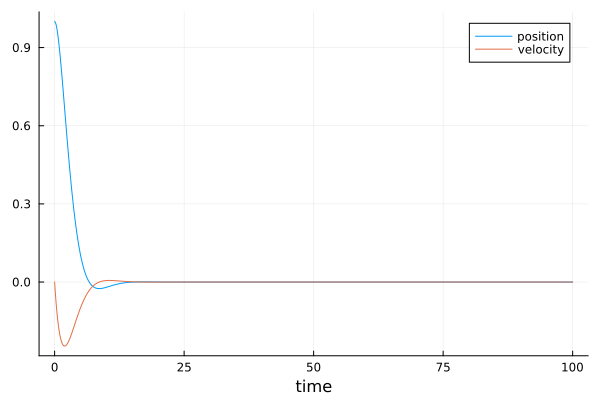

In [26]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times, x_hist[1,:], label="position")
plot!(times, x_hist[2,:], label="velocity")
xlabel!("time")

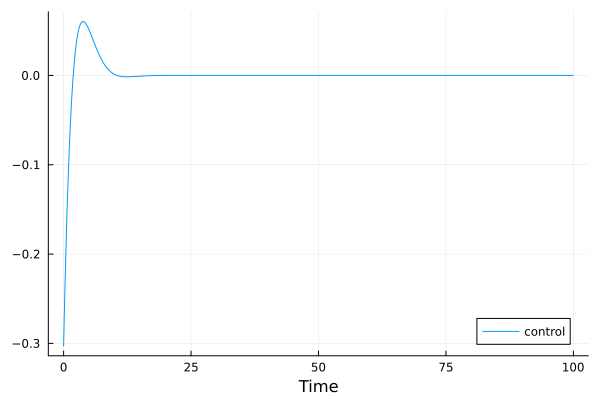

In [27]:
plot(times[1:end-1], u_hist, label="control")
xlabel!("Time")

In [28]:
J(x_hist,u_hist)

13.784997081960674

## Experiment - Extreme initial state

In [38]:
Tfinal = 50.0 # final time
N = Int(Tfinal/h)+1    # number of time steps

x0 = [75.0; -100]

2-element Vector{Float64}:
   75.0
 -100.0

In [39]:
H = blockdiag(R, kron(I(N-2), blockdiag(Q, R)), Qn)

C = kron(I(N-1), [B -I(n)])
for k in 1:(N-2)
    C[(k*n).+(1:n), (k*(m+n)-n).+(1:n)] .= A
end

d = [ -A*x0; zeros(size(C, 1) - n)]

z = [ H C'; C zeros(size(C, 1),size(C, 1)) ] \ [ zeros(size(H, 1)); d]

# parse state x and λ
state = z[1:size(H, 1)]
λ = z[size(H, 1)+1:end]

# reshape state into [ u; x ] form
state = reshape(state, m+n, (N-1))
u_hist = state[m,:]
x_hist = state[m+1:end,:]

# add initial state
x_hist = [ x0 x_hist ]

2×501 Matrix{Float64}:
   75.0   65.304    56.2055   47.6828   39.7147  …   7.42312e-8   6.52385e-8
 -100.0  -93.9191  -88.0525  -82.4002  -76.9618     -8.99705e-8  -8.98839e-8

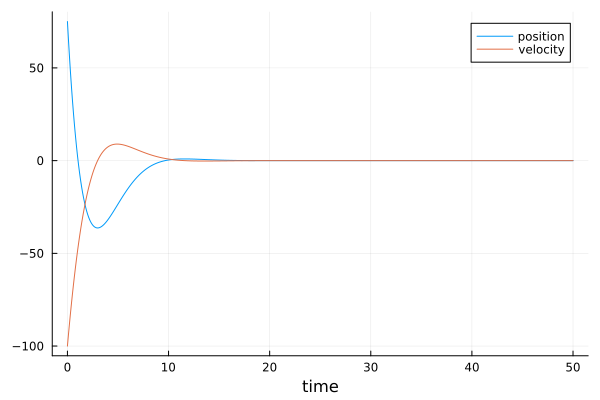

In [40]:
# Plot x1 vs. x2, u vs. t, x vs. t, etc.
times = range(0,h*(N-1), step=h)
plot(times, x_hist[1,:], label="position")
plot!(times, x_hist[2,:], label="velocity")
xlabel!("time")

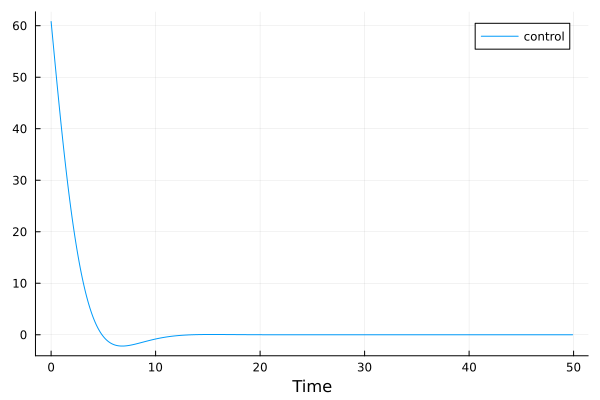

In [41]:
plot(times[1:end-1], u_hist, label="control")
xlabel!("Time")

In [42]:
J(x_hist,u_hist)

270907.8270304729